In [1]:
x=2

In [141]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import decoupler as dc

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
sc.set_figure_params(vector_friendly=True, figsize=(4,4))

In [4]:
adata = sc.read('../../pipeline/data/multigrate_mil_reg/pbmc_mtg_final1/old_7a87db1eef_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 2188
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    var: 'modality'
    uns: 'Site_colors', 'Status_on_day_collection_summary_colors', '_scvi_manager_uuid', '_scvi_uuid', 'full_clustering_colors', 'initial_clustering_colors', 'modality_lengths', 'neighbors', 'patient_id_colors', 'umap'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'
    layers: 'count

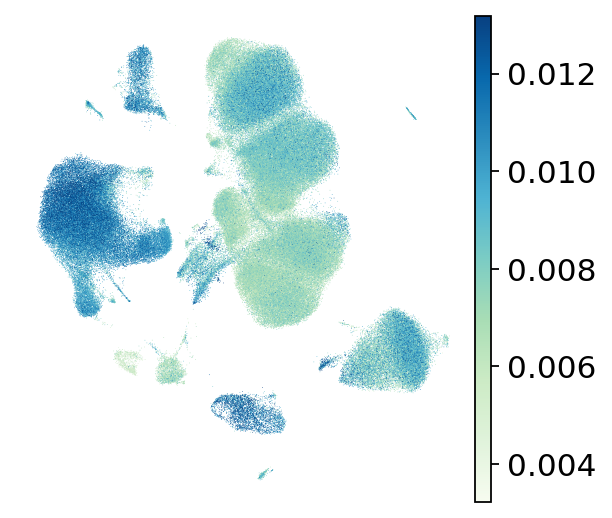

In [6]:
sc.pl.umap(
    adata,
    color=['cell_attn'],
    frameon=False,
    ncols=1,
    #palette=colors,
    color_map="GnBu",
    title='',
    legend_loc=None,
    vmax='p99',
    save='_pbmc_cell_attn.svg'
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


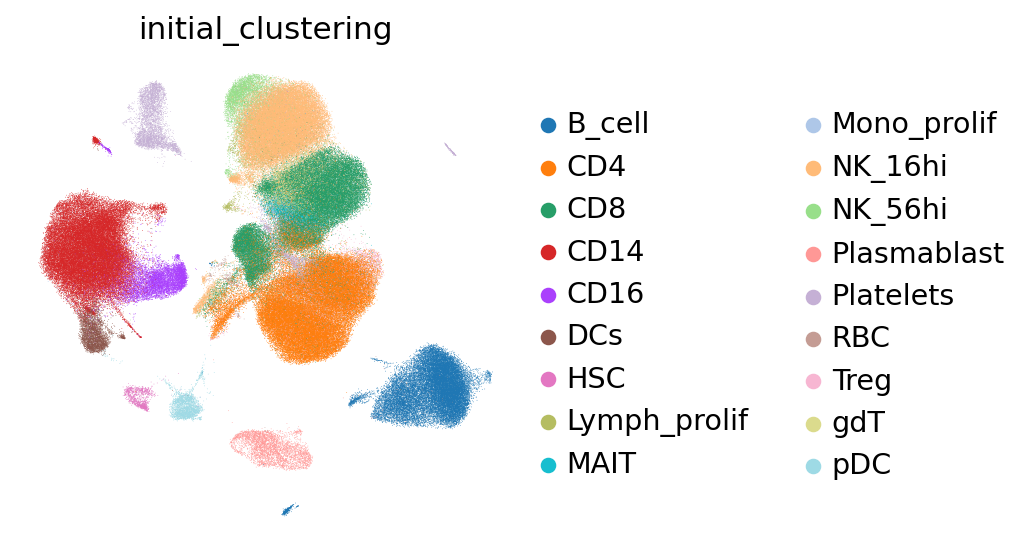

In [7]:
sc.pl.umap(adata, color=['initial_clustering'], ncols=1, frameon=False, save='_pbmc_celltypes.svg')

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


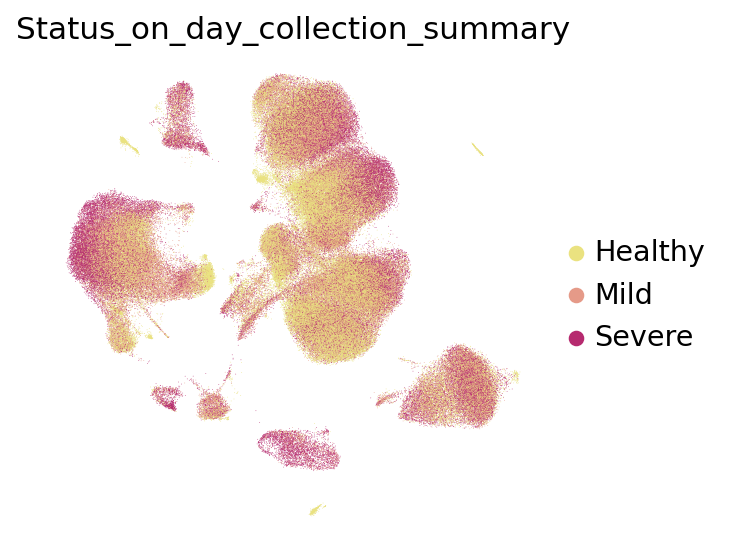

In [8]:
sc.pl.umap(adata, color=['Status_on_day_collection_summary'], palette=['#EAE280', '#E59A88', '#B62A6F'], ncols=1, frameon=False, save='_pbmc_cond.svg')

In [12]:
dfs = []
for cond in np.unique(adata.obs['Status_on_day_collection_summary']):
    adata_tmp = adata[adata.obs['Status_on_day_collection_summary'] == cond].copy()
    threshold_idx = int(len(adata_tmp) * 0.9)
    threshold_value = sorted(adata_tmp.obs['cell_attn'])[threshold_idx]
    adata_tmp.obs['group'] = 'all cells'
    adata_tmp.obs.loc[adata_tmp.obs['cell_attn'] >= threshold_value, 'group'] = 'top 10% cells'
    adata.obs[f'top_cells_{cond}'] = False
    adata.obs.loc[adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs_names, f'top_cells_{cond}'] = True
    adata.obs[f'top_cells_{cond}'] = adata.obs[f'top_cells_{cond}'].astype('category')
    dfs.append(adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs[['initial_clustering', 'Status_on_day_collection_summary']])

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


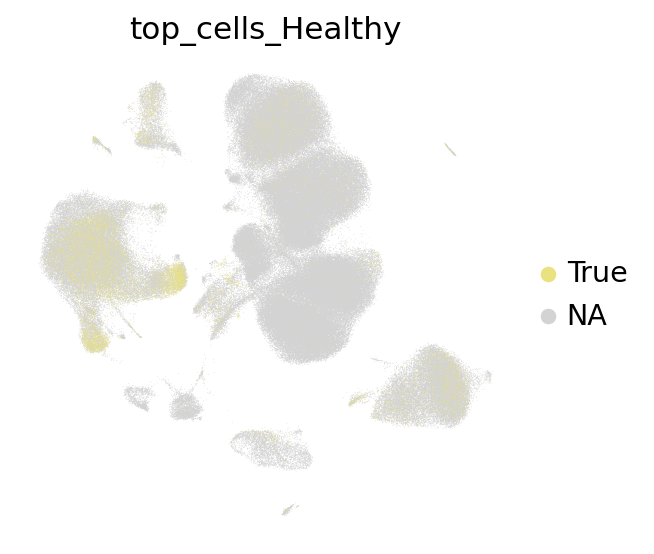

In [21]:
sc.pl.umap(adata, color=[f'top_cells_Healthy'], groups=[True], palette=['#EAE280'], frameon=False, save='_pbmc_top_healthy.svg')

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


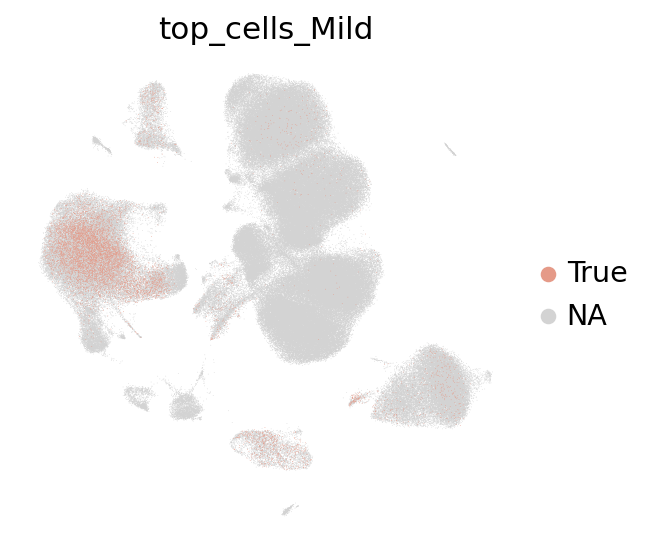

In [22]:
sc.pl.umap(adata, color=[f'top_cells_Mild'], groups=[True], palette=['#E59A88'], frameon=False, save='_pbmc_top_mild.svg')

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


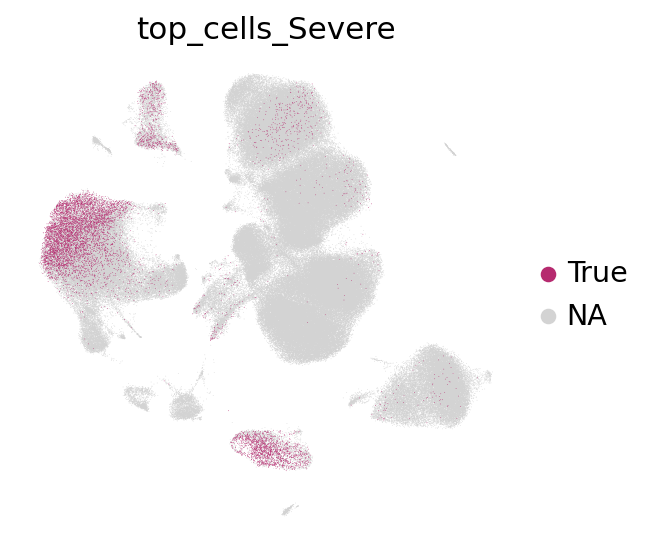

In [23]:
sc.pl.umap(adata, color=[f'top_cells_Severe'], groups=[True], palette=['#B62A6F'], frameon=False, save='_pbmc_top_severe.svg')

In [35]:
ct_df = adata.obs[['Status_on_day_collection_summary', 'initial_clustering']]
ct_df_group = ct_df.groupby('Status_on_day_collection_summary').value_counts(normalize=True).mul(100)
ct_df_group = ct_df_group.unstack().reindex(['Healthy', 'Mild', 'Severe']).T

In [36]:
ct_df_group['Mild - Healthy'] = (ct_df_group['Mild'] - ct_df_group['Healthy']) / ct_df_group['Healthy']
ct_df_group['Severe - Healthy'] = (ct_df_group['Severe'] - ct_df_group['Healthy']) / ct_df_group['Healthy']
ct_df_group['Severe - Mild'] = (ct_df_group['Severe'] - ct_df_group['Mild']) / ct_df_group['Healthy']
ct_df_group

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
B_cell,7.798926,10.613397,11.691050,0.360879,0.499059,0.138180
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
CD14,10.626655,18.917111,17.498243,0.780157,0.646637,-0.133520
CD16,3.571760,4.007579,1.963841,0.122018,-0.450176,-0.572194
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
HSC,0.148394,0.242733,1.020891,0.635737,5.879597,5.243860
Lymph_prolif,0.290605,1.330080,1.308375,3.576939,3.502250,-0.074689
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534


In [37]:
adata.obs['initial_clustering'].value_counts()

CD4             63893
CD8             41244
CD14            39282
NK_16hi         36366
B_cell          25288
CD16             8239
Platelets        6600
gdT              6117
Treg             5476
NK_56hi          5296
Plasmablast      3910
DCs              3807
MAIT             3386
pDC              2660
Lymph_prolif     2380
HSC              1139
RBC               793
Mono_prolif       175
Name: initial_clustering, dtype: int64

In [38]:
ct_df_group = ct_df_group.drop(['RBC', 'Mono_prolif'])

In [39]:
ct_df_group

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
B_cell,7.798926,10.613397,11.691050,0.360879,0.499059,0.138180
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
CD14,10.626655,18.917111,17.498243,0.780157,0.646637,-0.133520
CD16,3.571760,4.007579,1.963841,0.122018,-0.450176,-0.572194
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
HSC,0.148394,0.242733,1.020891,0.635737,5.879597,5.243860
Lymph_prolif,0.290605,1.330080,1.308375,3.576939,3.502250,-0.074689
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534


In [40]:
ct_df_group.sort_values('Mild - Healthy')

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534
gdT,3.701605,2.147448,1.010669,-0.419860,-0.726965,-0.307104
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
Platelets,2.210451,1.815547,3.819076,-0.178653,0.727736,0.906389
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
Treg,2.411402,2.128872,1.810516,-0.117164,-0.249185,-0.132021
NK_56hi,2.289801,2.184601,1.673801,-0.045943,-0.269019,-0.223076
NK_16hi,13.025691,12.726169,17.185204,-0.022995,0.319332,0.342326


In [41]:
ct_df_group.sort_values('Severe - Healthy')

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534
gdT,3.701605,2.147448,1.010669,-0.419860,-0.726965,-0.307104
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
CD16,3.571760,4.007579,1.963841,0.122018,-0.450176,-0.572194
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
NK_56hi,2.289801,2.184601,1.673801,-0.045943,-0.269019,-0.223076
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
Treg,2.411402,2.128872,1.810516,-0.117164,-0.249185,-0.132021
NK_16hi,13.025691,12.726169,17.185204,-0.022995,0.319332,0.342326


In [54]:
from matplotlib import pyplot as plt
import seaborn as sns

In [72]:
df = ct_df_group.loc[['Plasmablast', 'HSC', 'Lymph_prolif', 'pDC', 'Platelets']]

In [73]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))

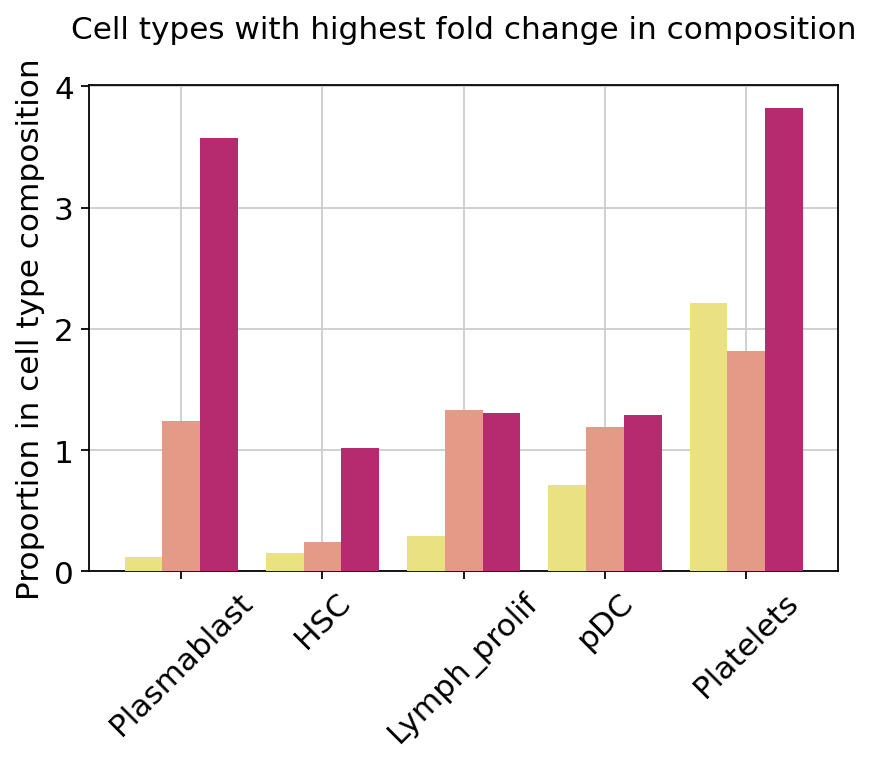

In [77]:
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
df[['Healthy', 'Mild', 'Severe']].plot.bar(color=['#EAE280', '#E59A88', '#B62A6F'], rot=45, legend=False, ax=ax, zorder=3, width=0.8)
plt.title('Cell types with highest fold change in composition\n')
plt.xlabel('')
plt.ylabel('Proportion in cell type composition')
plt.savefig('figures/bar_pbmc_proportions.svg', bbox_inches='tight')

In [79]:
df = pd.read_csv('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/reports/best.tsv', sep='\t', index_col=None)
task = 'pbmc_mtg_final1'

In [106]:
runs = {}
yerr = {}
df_task = df[df['task'] == task]
for method in np.unique(df_task['method']):
    runs[method] = eval(df_task.loc[df_task['method'] == method, 'accuracies'].values[0])
    yerr[method] = np.array(runs[method]).std()

df_tmp = df_task[['method', 'accuracy']]
df_tmp.index = df_tmp['method']
df_tmp = df_tmp[['accuracy']].sort_values('accuracy', ascending=False)
df_tmp = df_tmp.T

yerr_sorted = [yerr[method] for method in df_tmp.columns]

In [107]:
df_tmp.columns

Index(['multigrate_mil_reg', 'multigrate_mil', 'ct_pb_mr', 'ct_pb_nn', 'pb_nn',
       'ct_pb_rf', 'freq_rf', 'pb_rf', 'gex_rf', 'gex_nn', 'freq_nn',
       'freq_mr'],
      dtype='object', name='method')

In [108]:
df_tmp = df_tmp[['multigrate_mil_reg', 'multigrate_mil', 'ct_pb_mr', 'ct_pb_nn', 'ct_pb_rf', 'pb_nn', 'pb_rf', 'freq_rf', 'freq_nn', 'freq_mr', 'gex_rf', 'gex_nn']]

In [109]:
df_tmp.columns

Index(['multigrate_mil_reg', 'multigrate_mil', 'ct_pb_mr', 'ct_pb_nn',
       'ct_pb_rf', 'pb_nn', 'pb_rf', 'freq_rf', 'freq_nn', 'freq_mr', 'gex_rf',
       'gex_nn'],
      dtype='object', name='method')

In [110]:
df_tmp = df_tmp.rename(columns={
    'multigrate_mil_reg': 'Regression',
    'multigrate_mil': 'Classification',
    'ct_pb_mr': 'MR', 
    'ct_pb_nn': 'NN',
    'ct_pb_rf': 'RF', 
    'pb_nn': 'NN',
    'pb_rf': 'RF', 
    'freq_rf': 'RF', 
    'freq_nn': 'NN',
    'freq_mr': 'MR', 
    'gex_rf': 'RF', 
    'gex_nn': 'NN',
})

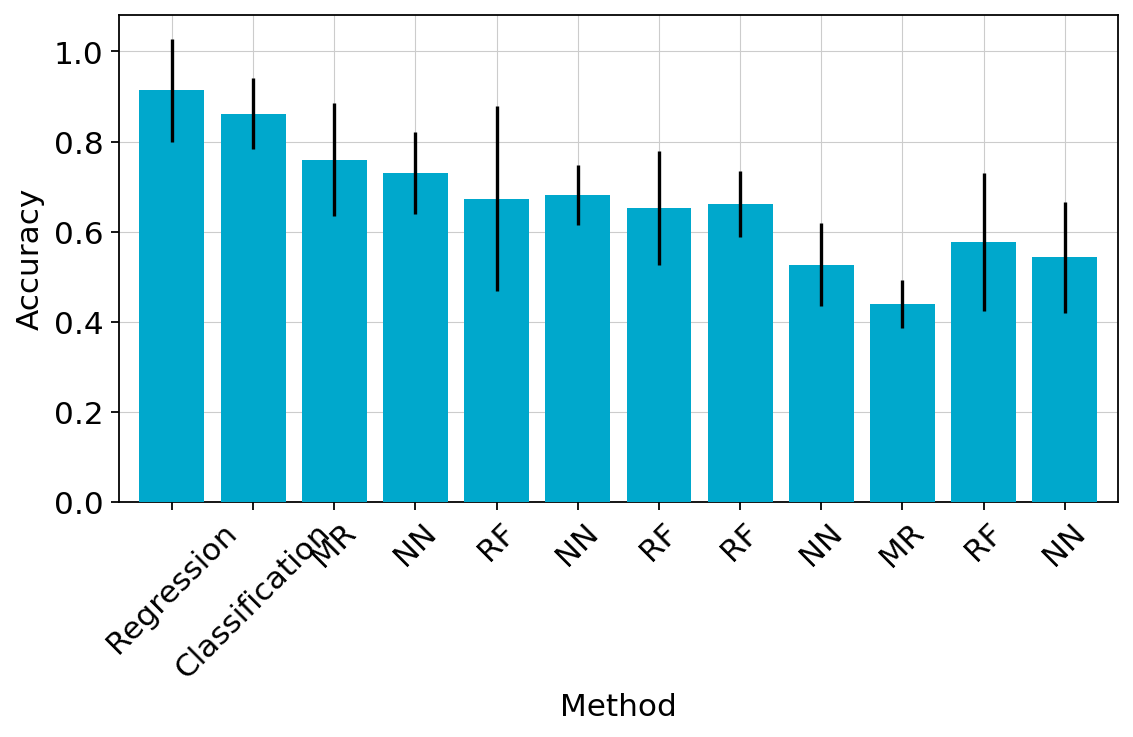

In [112]:
ax = df_tmp.T.plot(kind='bar', zorder=3, figsize=(8, 4), color=["#00a8cc"], rot=45, yerr=yerr_sorted, width=0.8)
ax.get_legend().remove()
ax.grid(zorder=0, linewidth=0.5)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('')
plt.savefig('figures/pbmc_accuracy.svg', bbox_inches='tight')

### patient repr

In [5]:
adata.obs

,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,full_clustering,initial_clustering,Resample,Collection_Day,...,split4,group,size_factors,_scvi_batch,cell_attn_0,cell_attn_1,cell_attn_2,cell_attn_3,cell_attn_4,cell_attn
covid_index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACCACGA-newcastle65,newcastle65,1351,1351,4278.0,178.0,4.160823,CD4.Naive,CD4,Initial,D0,...,train,0,2860.0,0,0.006984,0.010508,0.007746,0.008094,0.009821,0.008630
AAACCTGAGATGTCGG-newcastle65,newcastle65,1921,1921,4740.0,127.0,2.679325,NK_16hi,NK_16hi,Initial,D0,...,train,0,2653.0,0,0.008706,0.009597,0.007018,0.010422,0.006916,0.008532
AAACCTGAGGCGATAC-newcastle65,newcastle65,1056,1056,2875.0,198.0,6.886957,CD4.Naive,Treg,Initial,D0,...,train,0,1860.0,0,0.006629,0.006812,0.006780,0.007067,0.008227,0.007103
AAACCTGAGTACACCT-newcastle65,newcastle65,2140,2140,5260.0,316.0,6.007605,NK_16hi,NK_16hi,Initial,D0,...,train,0,2846.0,0,0.010812,0.006804,0.008089,0.008298,0.004918,0.007784
AAACCTGAGTGAATTG-newcastle65,newcastle65,1620,1620,4043.0,232.0,5.738313,CD8.EM,CD4,Initial,D0,...,train,0,2414.0,0,0.008731,0.006396,0.009405,0.007533,0.007770,0.007967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,BGCV15_CV0176,1631,1631,5325.0,184.0,3.455399,CD4.CM,CD4,Resample,D28,...,train,0,3486.0,0,0.009144,0.008453,0.006008,0.009347,0.005006,0.007592
BGCV15_TTTGGTTTCAAGATCC-1,BGCV15_CV0944,2503,2503,6681.0,264.0,3.951504,NK_16hi,NK_16hi,Initial,D0,...,train,0,3638.0,0,0.007179,0.006520,0.010105,0.011026,0.005119,0.007989
BGCV15_TTTGTCAAGGCGATAC-1,BGCV15_CV0176,2401,2401,8633.0,490.0,5.675895,CD4.CM,CD4,Resample,D28,...,train,0,5609.0,0,0.005247,0.006862,0.004765,0.006361,0.004114,0.005470


In [6]:
tmp = sc.AnnData(adata.obsm['latent'])
tmp.obs = adata.obs
tmp

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'

In [7]:
for i in range(tmp.X.shape[1]):
    tmp.obs[f'latent{i}'] = tmp.X[:, i].copy()
    tmp.obs[f'latent{i}_weighted'] = tmp.obs[f'latent{i}'] * tmp.obs['cell_attn']
tmp.obs[['latent0', 'latent0_weighted', 'cell_attn']]

,latent0,latent0_weighted,cell_attn
covid_index,,,
AAACCTGAGACCACGA-newcastle65,-0.170344,-0.001470,0.008630
AAACCTGAGATGTCGG-newcastle65,-1.007411,-0.008595,0.008532
AAACCTGAGGCGATAC-newcastle65,-0.251497,-0.001786,0.007103
AAACCTGAGTACACCT-newcastle65,-0.701973,-0.005464,0.007784
AAACCTGAGTGAATTG-newcastle65,-0.109289,-0.000871,0.007967
...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,0.413836,0.003142,0.007592
BGCV15_TTTGGTTTCAAGATCC-1,-0.254439,-0.002033,0.007989
BGCV15_TTTGTCAAGGCGATAC-1,-0.605825,-0.003314,0.005470


In [119]:
df = tmp.obs[[f'latent{i}' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0,latent1,latent2,latent3,latent4,latent5,latent6,latent7,latent8,latent9,...,latent12,latent13,latent14,latent15,latent16,latent17,latent18,latent19,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,0.344548,-0.150528,0.306088,-0.187310,0.218147,-0.077847,0.230981,-0.208586,-0.254200,0.043318,...,0.047392,-0.403155,-0.187793,-0.164077,-0.282662,0.319426,-0.171868,-0.065580,Severe,Sanger
AP4,0.165106,-0.236559,0.614609,-0.148086,-0.038765,-0.132805,0.151039,-0.324218,-0.330311,-0.025014,...,-0.030480,-0.076111,-0.179940,-0.233890,-0.197369,0.096934,-0.378309,-0.326807,Mild,Sanger
AP5,0.413475,-0.663631,-0.038010,-0.501842,-0.212037,-0.038159,-0.037974,-0.089472,-0.399102,-0.011391,...,-0.117136,-0.107880,-0.293442,-0.190262,0.079365,-0.133489,0.218204,-0.356163,Severe,Sanger


In [126]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [127]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [128]:
loo = LeaveOneOut()

In [129]:
mean_train_accuracies = {}
mean_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    mean_train_accuracies[k] = train_accuracies
    mean_test_accuracies[k] = test_accuracies

In [130]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(mean_train_accuracies[k])))
    print(np.mean(np.array(mean_test_accuracies[k])))

k = 3:
0.7976190476190476
0.6122448979591837
k = 5:
0.7351190476190476
0.6326530612244898
k = 7:
0.6968537414965985
0.6530612244897959
k = 9:
0.71343537414966
0.6122448979591837


In [61]:
sc.pp.neighbors(pb)

In [63]:
sc.tl.umap(pb)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


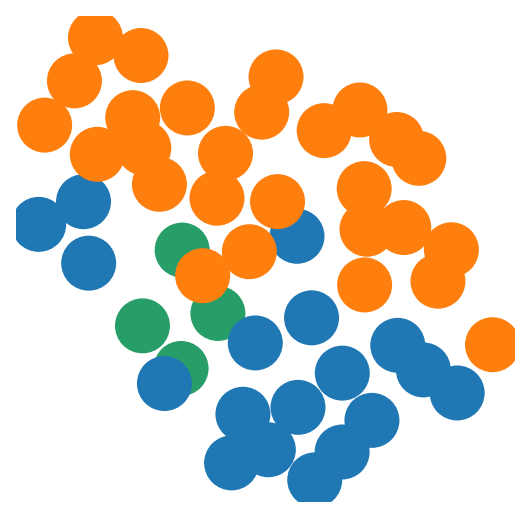

In [64]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_site.svg'
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


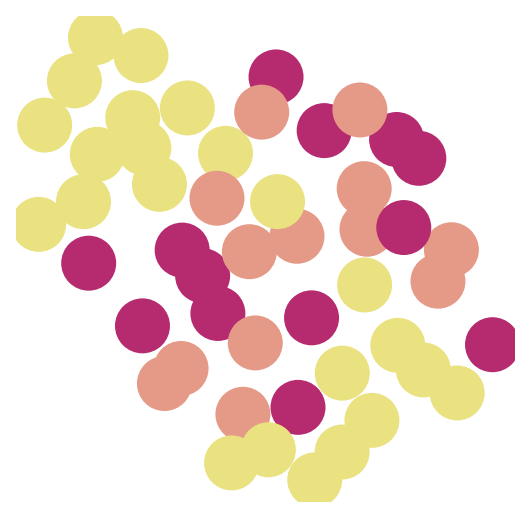

In [65]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr.svg'
)

In [131]:
df = tmp.obs[[f'latent{i}_weighted' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('sum')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0_weighted,latent1_weighted,latent2_weighted,latent3_weighted,latent4_weighted,latent5_weighted,latent6_weighted,latent7_weighted,latent8_weighted,latent9_weighted,...,latent12_weighted,latent13_weighted,latent14_weighted,latent15_weighted,latent16_weighted,latent17_weighted,latent18_weighted,latent19_weighted,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,13.026074,-4.893989,3.098428,-6.290412,8.211846,-3.652708,9.117825,-6.252129,-9.450863,1.531370,...,-0.686485,-14.229786,-6.743281,-6.576486,-13.793547,10.770847,-7.369116,0.608544,Severe,Sanger
AP4,11.278528,-14.312075,25.266010,-8.896774,-2.343004,-7.176126,10.740808,-19.308533,-20.616531,-1.393628,...,-8.229809,-4.761840,-7.286124,-15.869741,-18.887465,6.086495,-25.252813,-17.710005,Mild,Sanger
AP5,26.551291,-43.566593,-9.494485,-33.266926,-14.209946,-3.090642,-3.168029,-6.073105,-26.431049,-0.872598,...,-10.274695,-8.075554,-20.208918,-13.098352,4.384832,-10.057370,17.361012,-20.069386,Severe,Sanger


In [132]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [133]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [134]:
loo = LeaveOneOut()

In [135]:
attn_train_accuracies = {}
attn_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    attn_train_accuracies[k] = train_accuracies
    attn_test_accuracies[k] = test_accuracies

In [136]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(attn_train_accuracies[k])))
    print(np.mean(np.array(attn_test_accuracies[k])))

k = 3:
0.794642857142857
0.6938775510204082
k = 5:
0.7495748299319728
0.6530612244897959
k = 7:
0.6964285714285714
0.6326530612244898
k = 9:
0.6760204081632651
0.6122448979591837


In [138]:
df_test_accuracies = pd.DataFrame(attn_test_accuracies)
df_test_accuracies['type'] = 'MIL_reg'
df_test_accuracies.to_csv('csv/mil_reg_attn_test_accuracies.tsv', sep='\t')

In [73]:
sc.pp.neighbors(pb)

In [74]:
sc.tl.umap(pb)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


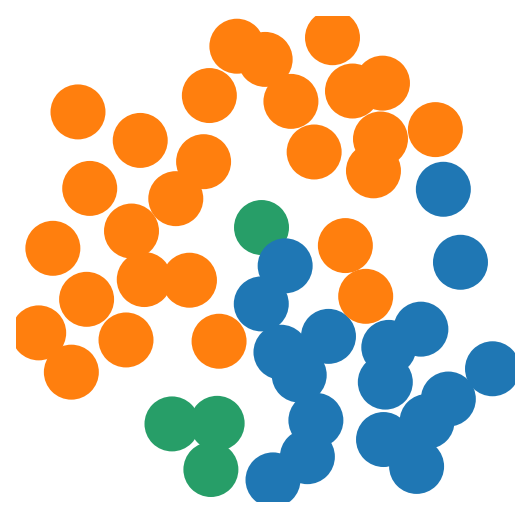

In [75]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_weighted_site.svg'
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


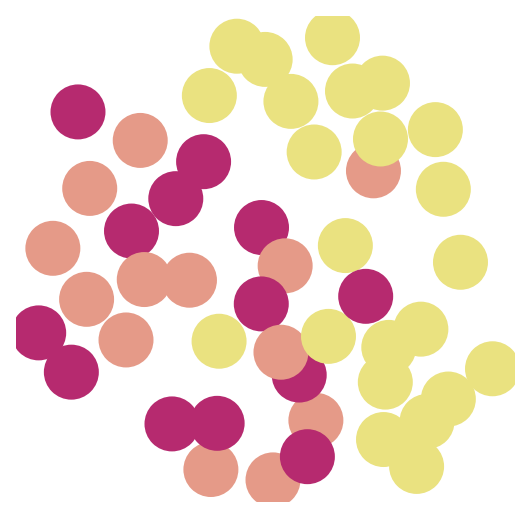

In [76]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_weighted.svg'
)

In [139]:
df1 = pd.DataFrame(attn_test_accuracies)
df2 = pd.DataFrame(mean_test_accuracies)

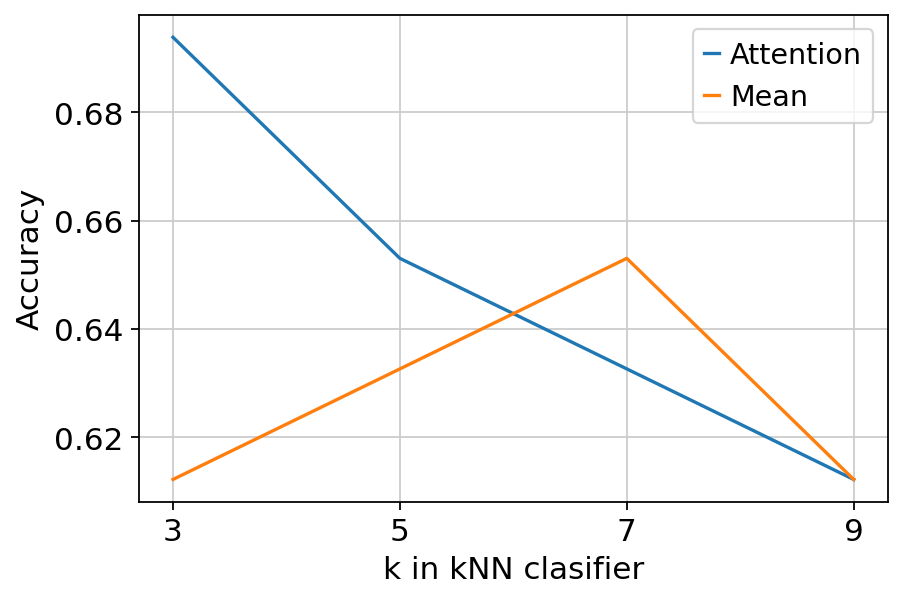

In [143]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
plt.plot(df1.mean().index.astype(str).values, df1.mean().values, label='Attention')
plt.plot(df2.mean().index.astype(str).values, df2.mean().values, label='Mean')
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mil_reg_knn_classifier.svg', bbox_inches='tight')